In [1]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [2]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_05b import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

**ConvNet**

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
  m, s = train.mean(), train.std()
  return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.8966e-08), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#eport
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1,1,28,28)

In [10]:
def get_cnn_model(data):
  return nn.Sequential(
      Lambda(mnist_resize),
      nn.Conv2d( 1, 8,5, padding=2, stride=2), nn.ReLU(),
      nn.Conv2d( 8,16,3, padding=1, stride=2), nn.ReLU(),
      nn.Conv2d(16,32,3, padding=1, stride=2), nn.ReLU(),
      nn.Conv2d(32,32,3, padding=1, stride=2), nn.ReLU(),
      nn.AdaptiveAvgPool2d(1),
      Lambda(flatten),
      nn.Linear(32, data.c)
  )

In [11]:
model = get_cnn_model(data)

In [12]:
#Copy this to any notebook complaining about recorder or statscallbacks
class AvgStats():
  def __init__(self, metrics, in_train):
    self.metrics = listify(metrics)
    self.in_train = in_train
    self.tot_loss = 0.
    self.count=0
    self.tot_mets = [0.] * len(self.metrics)

  def reset(self):
    self.tot_loss, self.count = 0.,0
    self.tot_mets = [0.] * len(self.metrics)
  
  @property
  def all_stats(self): return[self.tot_loss.item()] + self.tot_mets
  @property
  def avg_stats(self): return[o/self.count for o in self.all_stats]

  def __repr__(self):
    if not self.count: return ''
    return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

  def accumulate(self, run):
    bn = run.xb.shape[0]
    self.tot_loss += run.loss * bn
    self.count += bn
    for i,m in enumerate(self.metrics):
      self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
  def __init__(self, metrics):
    self.train_stats,self.valid_stats = AvgStats(metrics,True), AvgStats(metrics, False)

  def begin_epoch(self):
    self.train_stats.reset()
    self.valid_stats.reset()

  def after_loss(self):
    stats = self.train_stats if self.in_train else self.valid_stats
    with torch.no_grad(): stats.accumulate(self.run)

  def after_epoch(self):
    print(self.train_stats)
    print(self.valid_stats)

class Recorder(Callback):
  def begin_fit(self): self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [1.51070984375, tensor(0.4893)]
valid: [0.3570406494140625, tensor(0.8861)]
CPU times: user 3.85 s, sys: 129 ms, total: 3.98 s
Wall time: 4 s


**CUDA**

In [16]:
device = torch.device('cuda',0)

In [17]:
class CudaCallback(Callback):
  def __init__(self,device): self.device=device
  def begin_fit(self): self.model.to(device)
  def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)

In [18]:
torch.cuda.set_device(device)

In [19]:
class CudaCallback(Callback):
  def begin_fit(self): self.model.cuda()
  def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [2.02003703125, tensor(0.2889, device='cuda:0')]
valid: [0.68787724609375, tensor(0.7974, device='cuda:0')]
train: [2.02003703125, tensor(0.2889, device='cuda:0')]
valid: [0.72183046875, tensor(0.7847, device='cuda:0')]
train: [2.02003703125, tensor(0.2889, device='cuda:0')]
valid: [0.7244423076923077, tensor(0.7837, device='cuda:0')]
CPU times: user 3.57 s, sys: 1.02 s, total: 4.58 s
Wall time: 4.58 s


**Refactor**

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
  return nn.Sequential(
      nn.Conv2d(ni,nf,ks,padding=ks//2, stride=stride), nn.ReLU())

In [25]:
#export
class BatchTransformXCallback(Callback):
  _order=2
  def __init__(self, tfm): self.tfm = tfm

  def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
  def _inner(x): return x.view(*((-1,)+size))
  return _inner

In [26]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [27]:
nfs = [8,16,32,32]

In [28]:
def get_cnn_layers(data, nfs):
   nfs = [1] + nfs
   return [
      conv2d(nfs[i], nfs[i+1], 5 if i ==0 else 3)
      for i in range(len(nfs)-1)
   ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data,nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [29]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
  if opt_func is None: opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr = lr)
  learn = Learner(model, opt, loss_func, data)
  return learn, Runner(cb_funcs=listify(cbs))

In [30]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs = cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [37]:
run.fit(3, learn)

AttributeError: ignored

**HOOKS**

In [41]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds  = [[] for _ in layers]
    
  def __call__(self, x):
    for i,l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(x.data.mean())
      self.act_stds [i].append(x.data.std ())
    return x
  
  def __iter__(self): return iter(self.layers)

In [42]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs = cbfs)

In [45]:
run.fit(2,learn)

train: [2.2964334375, tensor(0.1396, device='cuda:0')]
valid: [2.2142016826923077, tensor(0.2091, device='cuda:0')]
train: [2.2964334375, tensor(0.1396, device='cuda:0')]
valid: [2.2142972039473685, tensor(0.2091, device='cuda:0')]


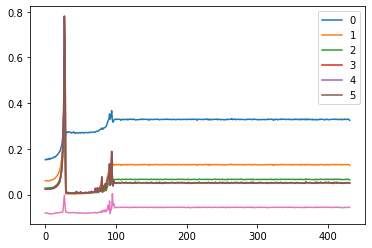

In [46]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6))

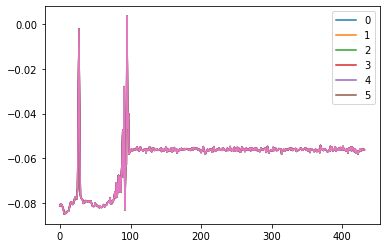

In [48]:
for i in model.act_stds: plt.plot(l)
plt.legend(range(6))

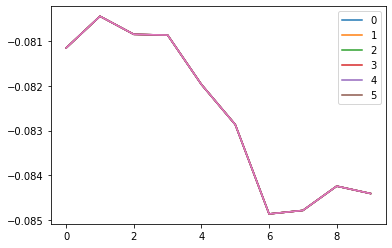

In [49]:
for i in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

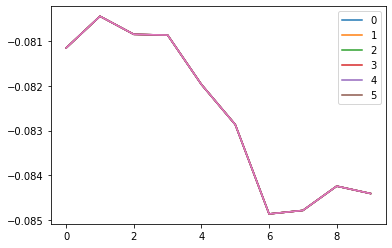

In [51]:
for i in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

**Pytorch Hooks**